### Objective:
To predict if a blood donor will return to donate blood in a specific time period


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#Import the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Renaming the ID column
train.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
test.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

### EDA begins

#Creating a profile report
import pandas_profiling
train_profile = pandas_profiling.ProfileReport(train)
train_profile.to_file('train_profile.html')

In [4]:
#Data preview
train.head()

,ID,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [5]:
train[train['Months since Last Donation'] == 1]

,ID,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
2,441,1,16,4000,35,1
4,358,1,24,6000,77,0
7,164,1,12,3000,35,0
11,285,1,13,3250,47,0
25,330,1,14,3500,58,0
57,607,1,9,2250,51,0
95,182,1,7,1750,57,0
403,258,1,10,2500,43,1
418,106,1,14,3500,95,0


##### Variables

In [6]:
# Variables
train.columns

Index(['ID', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')

In [7]:
train.describe()

,ID,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,374.034722,9.439236,5.427083,1356.770833,34.050347,0.239583
std,216.947773,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,0.000000,1.000000,250.000000,2.000000,0.000000
25%,183.750000,2.000000,2.000000,500.000000,16.000000,0.000000
50%,375.500000,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,562.500000,14.000000,7.000000,1750.000000,49.250000,0.000000
max,747.000000,74.000000,50.000000,12500.000000,98.000000,1.000000


* There are 576 data points
*  Number of Donations:
The number of donations range from 1 to 50. It will be interesting to see the distribution here.
* Total Volumne Donated:
Donation at each visit was 250 c.c. This is perfectly correlated with 'Number of Donations' and will be removed from any predictive model.
* Made Donation in March 2007
This is the target variable. **24%** of the train data has made a donation.

In [8]:
#Check for missing data. There is no missing data!
train.isnull().sum()

ID                             0
Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
Made Donation in March 2007    0
dtype: int64

#### Feature Creation

In [48]:
#Str Flag for visualization
train['Flag'] = train['Made Donation in March 2007'].astype(str)
#Single donor flag
train['single_donor'] = (train['Number of Donations'] == 1).astype('int')
# Difference between First and last donations
train[
    'diff'] = train['Months since First Donation'] - train['Months since Last Donation']
#Flag for very recent donations of 0 or 1 month
train['recent_donor'] = np.where(train['Months since Last Donation'] < 2, 1, 0)

#Log features
train['log Months since Last Donation'] = train['Months since Last Donation'].apply(lambda x: np.log(x+1))
train['log Number of Donations'] = train['Number of Donations'].apply(lambda x: np.log(x))
train['log Months since First Donation'] = train['Months since First Donation'].apply(lambda x: np.log(x))

In [49]:
#Creating the same features onthe test  set
#Single donor flag
test['single_donor'] = (test['Number of Donations'] == 1).astype('int')
# Difference between First and last donations
test[
    'diff'] = test['Months since First Donation'] - test['Months since Last Donation']
#Flag for very recent donations of 0 or 1 month
test['recent_donor'] = np.where(test['Months since Last Donation'] < 2, 1, 0)

#Log features
test['log Months since Last Donation'] = test['Months since Last Donation'].apply(lambda x: np.log(x+1))
test['log Number of Donations'] = test['Number of Donations'].apply(lambda x: np.log(x))
test['log Months since First Donation'] = test['Months since First Donation'].apply(lambda x: np.log(x))

### Visualizations

In [11]:
from plotnine import *

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Number of Donations**
* High number of donations over 20 are rare
* For low number of donations, the giving in march is a lower share

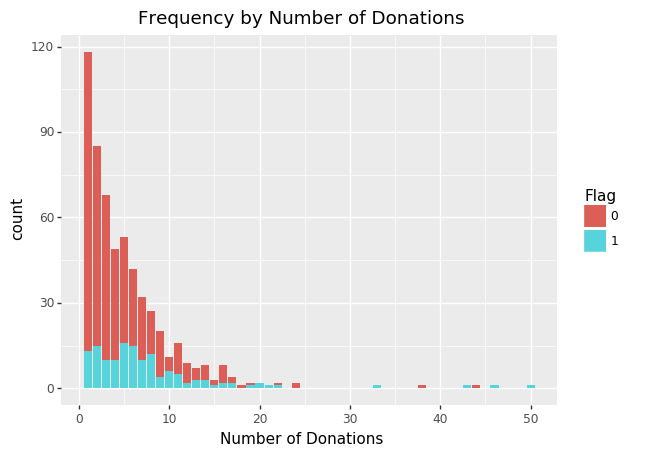

<ggplot: (144665158050)>

In [12]:
(ggplot(train) + aes(x='Number of Donations', fill='Flag') + geom_bar() +
 ggtitle('Frequency by Number of Donations'))

** Months since last donated**
* Those who have donated in the last 3 months have a higher probability of March donation.
* Those who donated 2 or 4 months away have a higher probability of donating.
* Maybe good to have a variable flag for that.

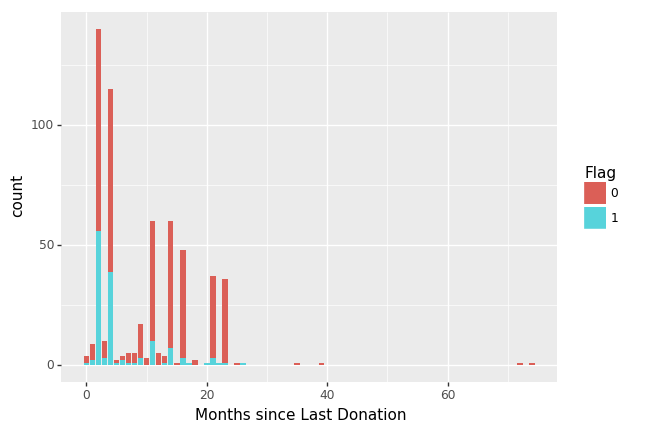

<ggplot: (144665158001)>

In [13]:
(ggplot(train) + aes(x='Months since Last Donation', fill='Flag') + geom_bar())

** Months since First Donation**
* There is no clear pattern with this data

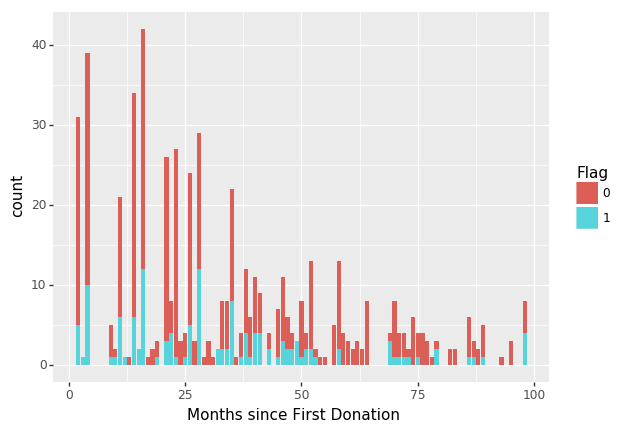

<ggplot: (144665268060)>

In [14]:
(ggplot(train) + aes(x='Months since First Donation', fill='Flag') +
 geom_bar())

#### Understanding Correlations among the variables

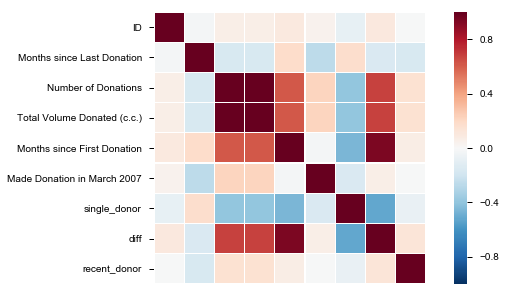

In [15]:
import seaborn as sns
plt.figure(figsize=[10, 5])

kw = {
    'axes.edgecolor': '0',
    'text.color': '0',
    'ytick.color': '0',
    'xtick.color': '0',
    'ytick.major.size': 5,
    'xtick.major.size': 5,
    'axes.labelcolor': '0'
}

sns.set_style("whitegrid", kw)
sns.heatmap(
    train.corr(),
    square=True,
    linecolor='White',
    linewidths=0.2,
    xticklabels=False)

#### Confusion Matrix Code

In [16]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

### Predictive Models

In [17]:
# The list of predictors
predictors = [
    'Months since Last Donation', 'Number of Donations',
    'Months since First Donation', 'single_donor', 'diff', 'recent_donor'
]

In [18]:
# train and validation split
from sklearn.model_selection import train_test_split

train_, valid = train_test_split(
    train, test_size=0.25, random_state=42)

In [19]:
train_.shape, valid.shape

((432, 10), (144, 10))

#### Logistic RegressionCV

In [20]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss

# Creating the model
lr_clf = LogisticRegressionCV(fit_intercept=True, cv=10, max_iter=400)

#Fiting on the training dataset
lr_clf.fit(train[predictors], train['Made Donation in March 2007'])

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=400,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [21]:
#Understanding the feature importance
lr_clf.coef_

array([[-0.05538048,  0.0698124 , -0.03217432, -0.00774706,  0.02320616,
        -0.00194415]])

In [22]:
# Predicting on the validation set
valid_clf_prob = lr_clf.predict_proba(train[predictors])
#Computing the log_loss metric
log_loss(y_true=train['Made Donation in March 2007'], y_pred=valid_clf_prob[:,1])

0.48848430285707223

In [23]:
#Predicting on the test data set
test_clf_prob = lr_clf.predict_proba(test[predictors])

In [24]:
#Looking at a confusion matrix for the training dataset
from sklearn.metrics import confusion_matrix
confused = confusion_matrix(train['Made Donation in March 2007'], lr_clf.predict(train[predictors]))

In [25]:
confused

array([[436,   2],
       [129,   9]])

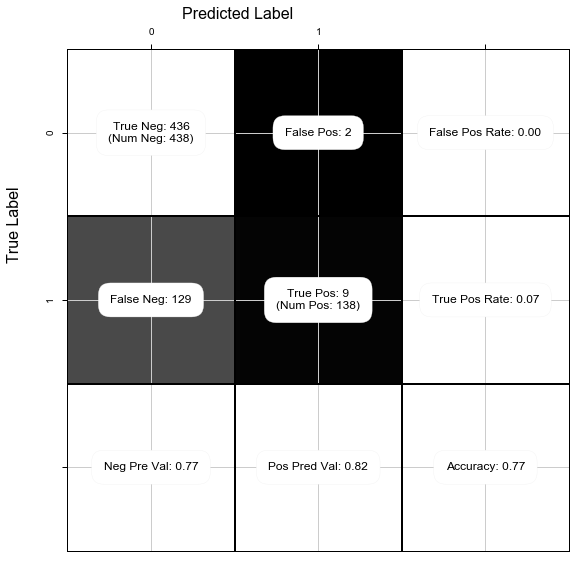

In [26]:
show_confusion_matrix(confused,class_labels=['0', '1'])

#Creating the submission file
submission = pd.DataFrame({'': test['ID'].values, 'Made Donation in March 2007': test_clf_prob[:,1]})


submission.to_csv('lr_v3.csv', index=False)

#### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

l_clf= LogisticRegression()

#Fiting on the training dataset
l_clf.fit(train[predictors], train['Made Donation in March 2007'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
# Predicting on the validation set
valid_l_clf_prob = l_clf.predict_proba(train[predictors])
#Computing the log_loss metric
log_loss(y_true=train['Made Donation in March 2007'], y_pred=valid_l_clf_prob[:,1])

0.47237498638170816

In [29]:
#Predicting on the test data
test_l_clf_prob = lr_clf.predict_proba(test[predictors])

#Creating the submission file
submission = pd.DataFrame({'': test['ID'].values, 'Made Donation in March 2007': test_l_clf_prob[:,1]})
submission.to_csv('lr_v4.csv', index=False)

#### TPOT

In [31]:
from tpot import TPOTClassifier

In [39]:
#Creating an instance
pipeline_optimizer = TPOTClassifier(verbosity=3, scoring='neg_log_loss', n_jobs=-1)

29 operators have been imported by TPOT.


In [40]:
pipeline_optimizer.fit(train[predictors], train['Made Donation in March 2007'] )

_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=2 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=3 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=4 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=5 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=5 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=6 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=7 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=8 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=9 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 1 - Current Pareto front scores:


1	0.5148113389200983	LogisticRegression(input_matrix, LogisticRegression__C=0.01, LogisticRegression__dual=DEFAULT, LogisticRegression__penalty=l2)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=5 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=6 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=5 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=6 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=7 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=8 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _mate_operator: num_test=9 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 84


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 85


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 85


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 2 - Current Pareto front scores:


1	0.5124775618557613	LogisticRegression(input_matrix, LogisticRegression__C=0.01, LogisticRegression__dual=DEFAULT, LogisticRegression__penalty=l1)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 3 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 4 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 52


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 52


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 52


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 52


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 5 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 6 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=7 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 80


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 7 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 8 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 9 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=7 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=8 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 10 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 11 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 70


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 70


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 12 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5028136064125527	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 75


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 75


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 13 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 14 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 85


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 15 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _mate_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 16 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5021659296324859	KNeighborsClassifier(StandardScaler(VarianceThreshold(CombineDFs(input_matrix, input_matrix), VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 17 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 18 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=4 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 19 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 20 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 21 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by StandardScaler.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=5 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=6 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=7 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 22 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 23 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 24 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 51


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 25 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 26 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 27 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 28 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 29 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 30 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=7 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=8 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=9 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 31 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=5 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=6 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 32 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=2 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 cosine was provided as affinity. Ward can only work with euclidean distances.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 33 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 60


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 60


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 60


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 60


_pre_test decorator: _random_mutation_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 60


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 34 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 75


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 75


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 35 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


4	0.5001560896955282	KNeighborsClassifier(StandardScaler(VarianceThreshold(ZeroCount(input_matrix), VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 36 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


4	0.5001560896955282	KNeighborsClassifier(StandardScaler(VarianceThreshold(ZeroCount(input_matrix), VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 37 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


4	0.5001560896955282	KNeighborsClassifier(StandardScaler(VarianceThreshold(ZeroCount(input_matrix), VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 77


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 77


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=7 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=8 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=9 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 38 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


4	0.5001560896955282	KNeighborsClassifier(StandardScaler(VarianceThreshold(ZeroCount(input_matrix), VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 manhattan was provided as affinity. Ward can only work with euclidean distances.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 39 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.5020209357557209	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


4	0.5001560896955282	KNeighborsClassifier(StandardScaler(VarianceThreshold(ZeroCount(input_matrix), VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 40 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 41 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 42 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 43 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 44 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.5027368874421715	KNeighborsClassifier(StandardScaler(CombineDFs(input_matrix, input_matrix)), KNeighborsClassifier__n_neighbors=67, KNeighborsClassifier__p=2, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=9 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 53


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 53


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 45 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 46 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 47 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 48 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 49 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 50 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 65


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 51 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 52 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 53 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 54 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 55 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 56 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 57 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 precomputed was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 58 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 81


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 81


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 81


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 81


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 99


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 59 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 60 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 61


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 61 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=5 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=6 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=7 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=8 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 89


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 62 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 63 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 64 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 65 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 66 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 67 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 57


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 57


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 57


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 57


_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=7 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 92


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 68 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 69 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 70 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=4 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 71 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 66


_pre_test decorator: _random_mutation_operator: num_test=3 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=7 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 60


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 72 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 'ExtraTreesClassifier'


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 73 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 74 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 75 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=7 l1 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 58


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 76 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 77 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 78 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 2 is required by FeatureAgglomeration.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 2 is required by FeatureAgglomeration.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 79 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=1 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=2 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=3 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=4 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=7 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=8 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=9 l2 was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 80 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 95


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 95


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 81 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 82 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 83 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 58


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 84 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 85 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 86 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 87 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 88 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 89 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 90 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=1 X contains negative values.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 91 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.05000


_pre_test decorator: _random_mutation_operator: num_test=1 No feature in X meets the variance threshold 0.05000


_pre_test decorator: _random_mutation_operator: num_test=2 No feature in X meets the variance threshold 0.05000


_pre_test decorator: _random_mutation_operator: num_test=3 No feature in X meets the variance threshold 0.05000


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=7 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=8 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=9 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 92 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 93 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=7 No feature in X meets the variance threshold 0.20000


_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 94 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 95 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 96 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=5 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=6 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 93


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 97 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 68


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 68


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 68


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 68


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=1 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=2 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=3 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 64


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 98 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 99 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=7 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=8 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=9 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MinMaxScaler.


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=4 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=5 manhattan was provided as affinity. Ward can only work with euclidean distances.


_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative


_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Generation 100 - Current Pareto front scores:


1	0.5080384419843438	LogisticRegression(input_matrix, LogisticRegression__C=0.001, LogisticRegression__dual=False, LogisticRegression__penalty=DEFAULT)


2	0.4953457537431108	KNeighborsClassifier(StandardScaler(input_matrix), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


3	0.4940086411162006	KNeighborsClassifier(StandardScaler(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.05)), KNeighborsClassifier__n_neighbors=83, KNeighborsClassifier__p=1, KNeighborsClassifier__weights=uniform)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        generations=100, max_eval_time_mins=5, max_time_mins=None,
        mutation_rate=0.9, n_jobs=4, offspring_size=100,
        population_size=100, random_state=None, scoring=None,
        subsample=1.0, verbosity=3, warm_start=False)

In [41]:
pipeline_optimizer.fitted_pipeline_

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.05)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=83, p=1,
           weights='uniform'))])

In [43]:
test_y = pipeline_optimizer.predict_proba(test[predictors])

In [44]:
submission = pd.DataFrame({'': test['ID'].values, 'Made Donation in March 2007': test_y[:,1]}) 
submission.to_csv('lr_v5- TPOT.csv', index=False)

In [50]:
pipeline_optimizer.score

<bound method TPOTBase.score of TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        generations=100, max_eval_time_mins=5, max_time_mins=None,
        mutation_rate=0.9, n_jobs=4, offspring_size=100,
        population_size=100, random_state=None, scoring=None,
        subsample=1.0, verbosity=3, warm_start=False)>

In [46]:
#Export the code
pipeline_optimizer.export('tpot_best.py')